In [1]:
from kaggle_datasets import KaggleDatasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_recall_curve, classification_report
from xgboost import XGBClassifier
import time
import shap
from scipy.stats import gaussian_kde
import math
from typing import Tuple, List, Optional, Dict
from sklearn.pipeline import Pipeline
from dataclasses import dataclass
from pandas.api.types import is_datetime64_any_dtype, is_bool_dtype
import xgboost as xgb

## Setup

In [2]:
# Download latest version
path =  "/kaggle/input/ibm-transactions-for-anti-money-laundering-aml"

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ibm-transactions-for-anti-money-laundering-aml


In [3]:
data_orig = pd.read_csv(path + '/HI-Small_Trans.csv')
data = data_orig.copy()

data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
data_accounts = pd.read_csv(path + '/HI-Small_accounts.csv')

data_accounts.head()

,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520
2,UK Bank #33,21884,80812BE00,800C47F50,Partnership #35397
3,Germany Bank #4815,32742,81047F300,80096F0B0,Corporation #48813
4,National Bank of Harrisburg,127390,80BD8CF00,800FB8760,Corporation #889


## Exploratory Analysis

In [5]:
data_eda = data.copy()

data_eda['Timestamp'] = pd.to_datetime(
    data_eda['Timestamp'],
    format='%Y/%m/%d %H:%M',   
    errors='coerce'    
)

interval = (data_eda['Timestamp'].max() - data_eda['Timestamp'].min()) / 20
data_eda['time_interval'] = np.round(
    (data_eda['Timestamp'] - data_eda['Timestamp'].min()) / interval
)

data_eda.drop(['Timestamp', 'Account', 'Account.1'], axis = 1, inplace = True)

In [6]:
for col in data_eda.columns:
    if data_eda[col].dtype == 'object' or pd.api.types.is_categorical_dtype(data_eda[col]):
        print(f'\n{col} — top 10 categories with counts')
        print(data_eda[col].value_counts(dropna=False).head(10))


Receiving Currency — top 10 categories with counts
Receiving Currency
US Dollar      1879341
Euro           1172017
Swiss Franc     237884
Yuan            206551
Shekel          194988
Rupee           192065
UK Pound        181255
Ruble           157361
Yen             156319
Bitcoin         148151
Name: count, dtype: int64

Payment Currency — top 10 categories with counts
Payment Currency
US Dollar      1895172
Euro           1168297
Swiss Franc     234860
Yuan            213752
Shekel          192184
Rupee           190202
UK Pound        180738
Yen             155209
Ruble           155178
Bitcoin         146066
Name: count, dtype: int64

Payment Format — top 10 categories with counts
Payment Format
Cheque          1864331
Credit Card     1323324
ACH              600797
Cash             490891
Reinvestment     481056
Wire             171855
Bitcoin          146091
Name: count, dtype: int64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead


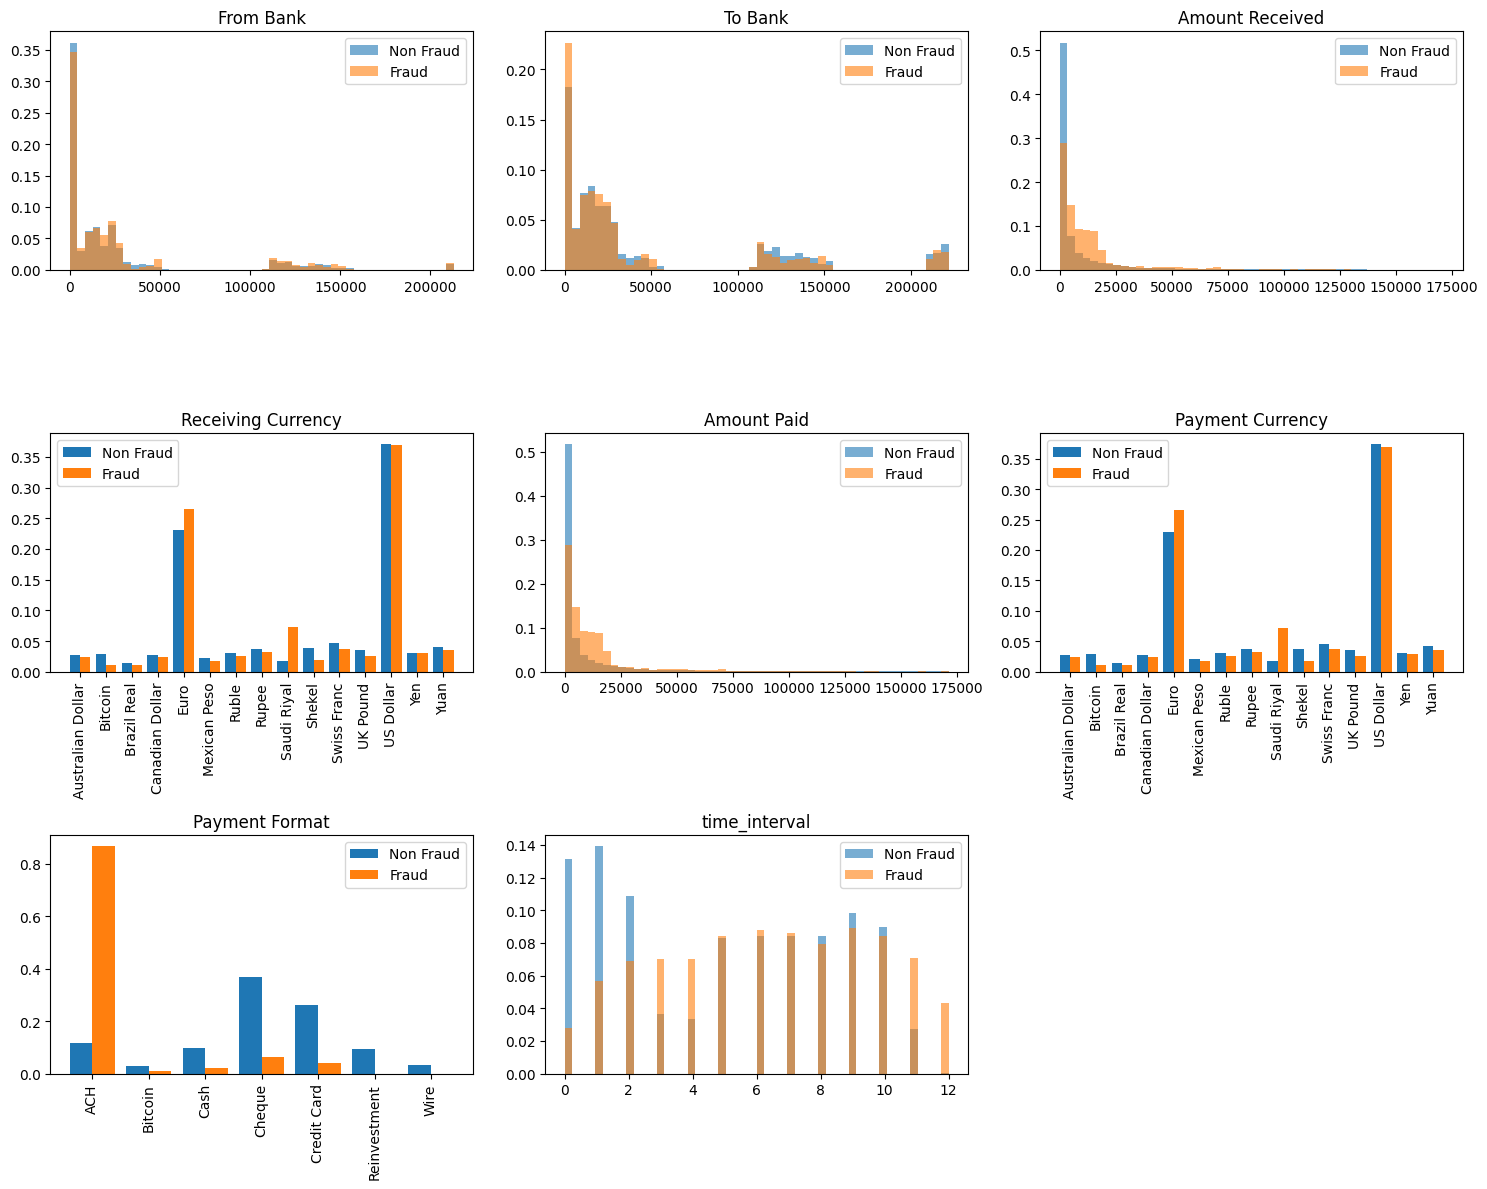

In [7]:
target = 'Is Laundering'

features = [col for col in data_eda if col != target]

n = len(features)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]

    if pd.api.types.is_numeric_dtype(data_eda[col]):
        x0 = data_eda.loc[data_eda[target] == 0, col].dropna()
        x1 = data_eda.loc[data_eda[target] == 1, col].dropna()

        q_low  = min(x0.quantile(0.1), x1.quantile(0.1))
        q_high = max(x0.quantile(0.9), x1.quantile(0.9))

        ax.hist(
            x0, bins=50, range=(q_low, q_high),
            weights=np.ones_like(x0) / len(x0),
            alpha=0.6, label='Non Fraud'
        )
        ax.hist(
            x1, bins=50, range=(q_low, q_high),
            weights=np.ones_like(x1) / len(x1),
            alpha=0.6, label='Fraud'
        )
    else:
        vc0 = data_eda.loc[data_eda[target] == 0, col].value_counts(normalize=True, dropna=False)
        vc1 = data_eda.loc[data_eda[target] == 1, col].value_counts(normalize=True, dropna=False)
        cats = vc0.index.union(vc1.index)
        vals0 = vc0.reindex(cats, fill_value=0).to_numpy()
        vals1 = vc1.reindex(cats, fill_value=0).to_numpy()
        x = np.arange(len(cats))
        width = 0.4
        ax.bar(x - width / 2, vals0, width, label='Non Fraud')
        ax.bar(x + width / 2, vals1, width, label='Fraud')
        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=90)

    ax.set_title(col)
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Some observations:

- Amount received / paid has a more skewed distribution in fraudulent cases. Micropayments are very likely to be legitimate, and large payments are more likely than average to be fraudulent (although still quite unlikely given the natural frequencies of fraudlent vs. legitimate payments)
- Fraud is extremely likely to occur via ACH format

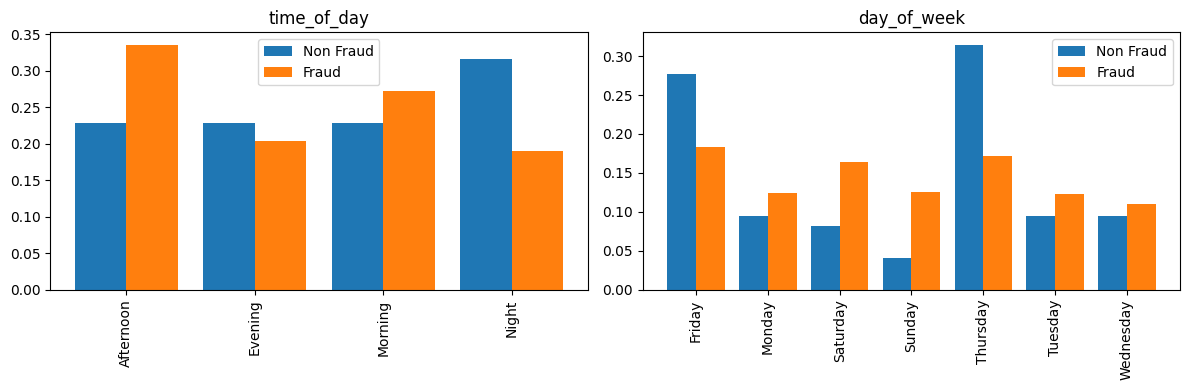

In [8]:
data_eda['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M', errors='coerce')

h = data_eda['Timestamp'].dt.hour
data_eda['time_of_day'] = np.select(
    [h<6, h<12, h<18], ['Night','Morning','Afternoon'], default='Evening'
)
data_eda['day_of_week'] = data_eda['Timestamp'].dt.day_name()

time_vars = ['time_of_day','day_of_week']

n = len(time_vars)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols,4*rows))
axes = np.reshape(axes, -1)

for i, col in enumerate(time_vars):
    ax = axes[i]
    vc0 = data_eda.loc[data_eda[target]==0, col].value_counts(normalize=True, dropna=False)
    vc1 = data_eda.loc[data_eda[target]==1, col].value_counts(normalize=True, dropna=False)
    cats = vc0.index.union(vc1.index)
    v0 = vc0.reindex(cats, fill_value=0).to_numpy()
    v1 = vc1.reindex(cats, fill_value=0).to_numpy()
    x = np.arange(len(cats)); w=0.4
    ax.bar(x-w/2, v0, w, label='Non Fraud'); ax.bar(x+w/2, v1, w, label='Fraud')
    ax.set_xticks(x); ax.set_xticklabels(cats, rotation=90); ax.set_title(col); ax.legend()

for j in range(i+1, len(axes)): fig.delaxes(axes[j])
fig.tight_layout(); plt.show()

There is evidence of some time-based dependencies. Since concepts like 'afternoon' depend on where you are in the world (it is always afternoon somewhere!), I suspect these are actually proxies for location.

In [9]:
mask_same = data['To Bank'].eq(data['From Bank'])
mask_diff = ~mask_same

same_bank_fraud_rate      = data.loc[mask_same, target].mean()
different_bank_fraud_rate = data.loc[mask_diff, target].mean()

rate_of_same_bank = len(data[data['To Bank'] == data['From Bank']])/len(data)

print(f"Rate of fraud (x1000) when transfer is bank-internal: {np.round(same_bank_fraud_rate * 1000, 2)}. Rate of fraud (x1000) when transfer is bank external: {np.round(different_bank_fraud_rate * 1000, 3)}")
print(f"Internal bank transfers occur {np.round(rate_of_same_bank * 100, 1)}% of the time")

Rate of fraud (x1000) when transfer is bank-internal: 0.15. Rate of fraud (x1000) when transfer is bank external: 1.157
Internal bank transfers occur 13.6% of the time


Fraud is 10x more likely to occur when a transfer is made from an account in one bank to an account in another than when the transfer is between two accounts in the same bank

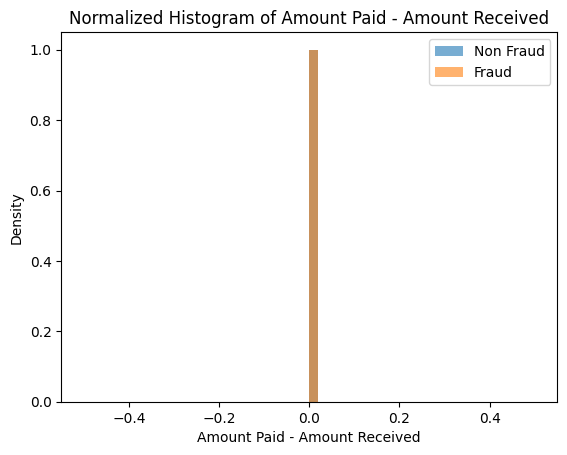

In [10]:
diff = data_eda['Amount Paid'] - data_eda['Amount Received']

mask_nonfraud = data_eda['Is Laundering'] == 0
mask_fraud = data_eda['Is Laundering'] == 1

# clip to 1st and 99th percentiles to reduce extreme outliers
low, high = np.percentile(diff, [1, 99])

vals_nonfraud = diff[mask_nonfraud].clip(low, high)
vals_fraud = diff[mask_fraud].clip(low, high)

bins = 50

plt.figure()
plt.hist(vals_nonfraud, bins=bins,
         weights=np.ones_like(vals_nonfraud) / len(vals_nonfraud), alpha=0.6, label='Non Fraud')
plt.hist(vals_fraud, bins=bins,
         weights=np.ones_like(vals_fraud) / len(vals_fraud), alpha=0.6, label='Fraud')
plt.title('Normalized Histogram of Amount Paid - Amount Received')
plt.xlabel('Amount Paid - Amount Received')
plt.ylabel('Density')
plt.legend()
plt.show()

Amount paid and amount received are practically identical. We can drop one 

Exact currency match rate: 0.9857886772166916

Top mismatch pairs (share of all rows):
Receiving Currency  Payment Currency
Euro                US Dollar           0.219454
US Dollar           Euro                0.153249
                    Yuan                0.092490
Yuan                US Dollar           0.035292
Swiss Franc         US Dollar           0.034737
UK Pound            US Dollar           0.034488
Rupee               US Dollar           0.032008
Shekel              US Dollar           0.030539
Yen                 US Dollar           0.028086
Ruble               US Dollar           0.026798
Name: proportion, dtype: float64


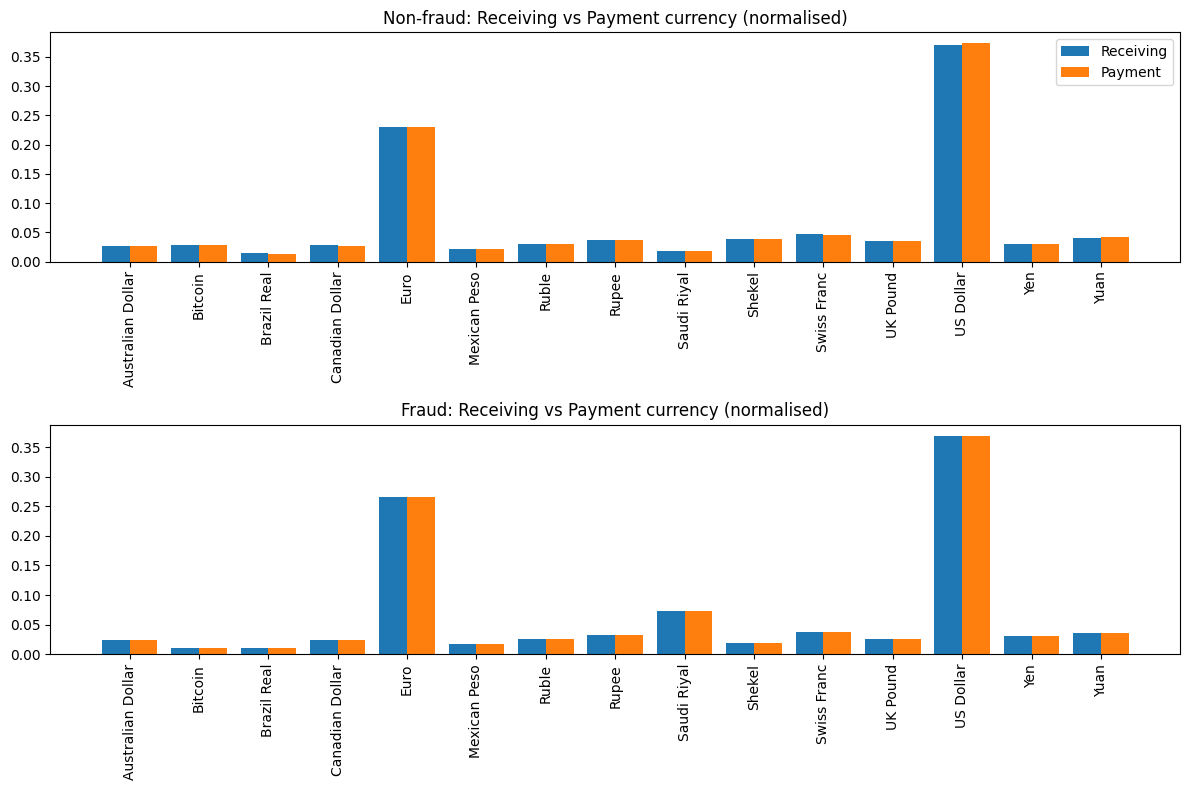

In [11]:
match_rate = (data['Receiving Currency'] == data['Payment Currency']).mean()
print('Exact currency match rate:', match_rate)

mismatch_pairs = (
    data.loc[data['Receiving Currency'] != data['Payment Currency'],
             ['Receiving Currency','Payment Currency']]
    .value_counts(normalize=True)
    .head(10)
)
print('\nTop mismatch pairs (share of all rows):')
print(mismatch_pairs)

cats = pd.Index(data['Receiving Currency'].dropna().unique()).union(
       pd.Index(data['Payment Currency'].dropna().unique()))

def class_bars(cls, ax, title):
    rc = (data.loc[data[target]==cls, 'Receiving Currency']
            .value_counts(normalize=True, dropna=False)
            .reindex(cats, fill_value=0))
    pc = (data.loc[data[target]==cls, 'Payment Currency']
            .value_counts(normalize=True, dropna=False)
            .reindex(cats, fill_value=0))
    x = np.arange(len(cats)); w = 0.4
    ax.bar(x - w/2, rc.values, w, label='Receiving')
    ax.bar(x + w/2, pc.values, w, label='Payment')
    ax.set_xticks(x); ax.set_xticklabels(cats, rotation=90)
    ax.set_title(title)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
class_bars(0, axes[0], 'Non‑fraud: Receiving vs Payment currency (normalised)')
class_bars(1, axes[1], 'Fraud: Receiving vs Payment currency (normalised)')
axes[0].legend()
fig.tight_layout(); plt.show()

pairs = data.groupby(['Receiving Currency','Payment Currency']).size()
mat = (pairs.unstack(fill_value=0)
            .reindex(index=cats, columns=cats, fill_value=0))
row_sums = mat.sum(axis=1).replace(0, np.nan)
mat_norm = mat.div(row_sums, axis=0)

Fraudulent transactions are almost always paid and received in the same currency. We'll include an indicator variable for cross currency

## Feature Engineering

Based on the analysis above, we are going to add the following features:

- 90th percentile or above, and 10th percentile or below indicator variables for amount paid and amount received. The differences between the distributions is most evident at the tails. Hopefully this will help the model distinguish
- Time of day, day of week variables. We can use a sinosoidal function to encode these to capture their periodic nature
- I might bundle some of the currencies together. One-hot encoding all of them will increase dimension substantially for relatively little extra signal. Only a few currencies are highly indicative of fraud or not-fraud
- Internal or external bank transfer indicator variable
- Cross-currency transaction indicator variable
- Log-transformed variable for amounts, which is a highly skewed distribution

In [12]:
def feature_engineering_V1(
    data: data
):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M', errors='coerce')
    
    for c in ['Amount Paid', 'Amount Received']:
        q10, q90 = data[c].quantile([0.10, 0.90])
        data[f'{c}_low10']  = (data[c] <= q10).astype(int)
        data[f'{c}_high90'] = (data[c] >= q90).astype(int)
        data[f'log_{c}']    = np.log1p(data[c])

    h   = data['Timestamp'].dt.hour
    dow = data['Timestamp'].dt.dayofweek
    data['tod_sin'] = np.sin(2*np.pi*h/24)
    data['tod_cos'] = np.cos(2*np.pi*h/24)
    data['dow_sin'] = np.sin(2*np.pi*dow/7)
    data['dow_cos'] = np.cos(2*np.pi*dow/7)
    
    top_k = 6
    top_curr = pd.Index(
        pd.concat([data['Receiving Currency'], data['Payment Currency']]).value_counts().nlargest(top_k).index
    )
    data['ReceivingCurrGrp'] = np.where(data['Receiving Currency'].isin(top_curr),
                                        data['Receiving Currency'], 0)
    data['PaymentCurrGrp']   = np.where(data['Payment Currency'].isin(top_curr),
                                        data['Payment Currency'], 'Other')
    
    rc = pd.get_dummies(data['ReceivingCurrGrp'], prefix='rc')
    pc = pd.get_dummies(data['PaymentCurrGrp'],   prefix='pc')
    pf = pd.get_dummies(data['Payment Format'], prefix = 'pf')
    data = pd.concat([data, rc, pc, pf], axis=1)
    
    data['internal_transfer'] = (data['From Bank'] == data['To Bank']).astype(int)
    data['cross_currency']    = (data['Receiving Currency'] != data['Payment Currency']).astype(int)

    return data


data = feature_engineering_V1(data)

## Preprocessing #1

Drop account variables, which have very high cardinality and probably don't add very much information. Later on, we will upsample the minority class, but I want to be sure this helps, so we'll set a baseline without any upsampling

In [13]:
data.drop(['Account','Account.1', 'Payment Currency', 'Receiving Currency', 'Payment Format', "ReceivingCurrGrp", 'PaymentCurrGrp'], axis = 1, inplace = True)

We have to be cognissant of the time split. We want to prevent data leakage, so we'll apply an expanding walk forward framework with an embargo of 24 hours between train & test sets. The embargo ensures no data leakage, as the same crime group may be operating over a several hour period, and, without the embargo, the split could come right in the middle.

In [14]:
def chronological_purged_cv(
    df: pd.DataFrame,
    ts_col: str = "Timestamp",
    n_splits: int = 5,
    *,
    test_fraction: float = 0.15,
    test_rows: Optional[int] = None,
    embargo: pd.Timedelta = pd.Timedelta(0),
    min_test_rows: int = 1,
    label_col: Optional[str] = None,
    min_test_pos: int = 0,
) -> List[Dict]:
    """
    Chronological CV with **equal-row partitions** (by count), not equal time.

    - Sort all rows by time.
    - Split the *sorted index* into ``n_splits`` contiguous blocks with (approximately) the same number of rows.
    - For each block, the test set is the **last `test_rows` rows** of the block. If ``test_rows`` is ``None``,
      it uses ``ceil(test_fraction * block_size)``. A floor of ``min_test_rows`` is enforced.
    - Training set = **all rows with timestamp < (test_start_time - embargo)** across the whole dataset.
      This yields expanding, purged training windows and avoids any future leakage.
    - If ``label_col`` is provided, the function will check the number of positives in each test set and warn
      (or, if ``min_test_pos>0``, it will grow the test set backwards within the block to try to reach the target.
      If it still cannot, it keeps the maximal available block and warns.)

    Returns a list of dicts per fold with indices and date ranges.
    """
    if ts_col not in df.columns:
        raise KeyError(f"{ts_col} not in dataframe")

    d = df[[ts_col]].dropna(subset=[ts_col])
    if d.empty:
        raise ValueError("No non-null timestamps available after parsing.")

    # Global sorted index by time
    order = d[ts_col].sort_values().index
    ts_sorted = df.loc[order, ts_col]

    n = len(order)
    if n_splits <= 0:
        raise ValueError("n_splits must be >= 1")
    if n_splits > n:
        raise ValueError("n_splits cannot exceed number of rows")

    # Row-quantile boundaries
    cuts = np.linspace(0, n, n_splits + 1, dtype=int)

    folds: List[Dict] = []
    for i in range(n_splits):
        lo, hi = cuts[i], cuts[i + 1]
        part_idx = order[lo:hi]
        if len(part_idx) == 0:
            continue

        part_start_time = df.loc[part_idx[0], ts_col]
        part_end_time   = df.loc[part_idx[-1], ts_col]

        block_size = len(part_idx)
        desired_test = test_rows if test_rows is not None else int(np.ceil(test_fraction * block_size))
        desired_test = max(desired_test, min_test_rows)
        desired_test = min(desired_test, block_size)  # cannot exceed block size

        # Select last `desired_test` rows of the block as test
        test_idx = part_idx[-desired_test:]
        test_start_time = df.loc[test_idx[0], ts_col]
        test_end_time   = df.loc[test_idx[-1], ts_col]

        # If label constraint provided, try to widen within the block
        if label_col is not None and min_test_pos > 0 and label_col in df.columns:
            pos_count = int(df.loc[test_idx, label_col].sum())
            if pos_count < min_test_pos:
                # widen backwards inside the block
                need = min_test_pos - pos_count
                # grow by chunks of 5% of the block or at least 100 rows each step
                step = max(100, block_size // 20)
                take = desired_test
                while pos_count < min_test_pos and take < block_size:
                    take = min(block_size, take + step)
                    test_idx = part_idx[-take:]
                    pos_count = int(df.loc[test_idx, label_col].sum())
                test_start_time = df.loc[test_idx[0], ts_col]
                test_end_time   = df.loc[test_idx[-1], ts_col]
                if pos_count < min_test_pos:
                    print(
                        f"Warning: fold {i+1} reached only {pos_count} positives (< {min_test_pos}) "
                        f"with entire block of {block_size} rows."
                    )
        elif label_col is not None and label_col not in df.columns:
            print(f"Warning: label_col '{label_col}' not found; skipping min_test_pos checks.")

        # Training: all rows strictly before (test_start_time - embargo)
        train_cut_time = test_start_time - embargo
        train_mask = ts_sorted < train_cut_time
        train_idx = ts_sorted.index[train_mask]

        folds.append(
            dict(
                fold=i + 1,
                train_idx=train_idx,
                test_idx=test_idx,
                part_start=part_start_time,
                part_end=part_end_time,
                test_start=test_start_time,
                test_end=test_end_time,
                train_end=train_cut_time,
                n_train=len(train_idx),
                n_test=len(test_idx),
            )
        )

    if len(folds) < n_splits:
        print(
            f"Warning: produced {len(folds)} folds (requested {n_splits}). Some partitions were empty."
        )

    return folds

In [15]:
if __name__ == "__main__":
    # Assuming `data` exists and Timestamp parsed
    splits = chronological_purged_cv(
        data,
        ts_col="Timestamp",
        n_splits=5,
        test_fraction=0.15,                 # ~15% of each block used for testing
        embargo=pd.Timedelta(hours=12),      # gap to avoid leakage near boundary
        min_test_rows=50_000,                # ensure stable metrics
        label_col="Is Laundering",         # optional: check positives
        min_test_pos=100,                    # aim for at least 100 positives per test
    )

for f in splits:
    print(
        f"Fold {f['fold']}:\n"
        f"  Partition   : {f['part_start']} → {f['part_end']}\n"
        f"  Train end   : < {f['train_end']}  (n={f['n_train']})\n"
        f"  Test window : {f['test_start']} → {f['test_end']}  (n={f['n_test']})\n"
    )


Fold 1:
  Partition   : 2022-09-01 00:00:00 → 2022-09-01 21:03:00
  Train end   : < 2022-09-01 01:28:00  (n=359727)
  Test window : 2022-09-01 13:28:00 → 2022-09-01 21:03:00  (n=253917)

Fold 2:
  Partition   : 2022-09-01 21:03:00 → 2022-09-03 18:25:00
  Train end   : < 2022-09-02 12:15:00  (n=1507679)
  Test window : 2022-09-03 00:15:00 → 2022-09-03 18:25:00  (n=152351)

Fold 3:
  Partition   : 2022-09-03 18:25:00 → 2022-09-06 13:36:00
  Train end   : < 2022-09-05 17:47:00  (n=2646207)
  Test window : 2022-09-06 05:47:00 → 2022-09-06 13:36:00  (n=152351)

Fold 4:
  Partition   : 2022-09-06 13:36:00 → 2022-09-08 16:12:00
  Train end   : < 2022-09-07 20:27:00  (n=3662698)
  Test window : 2022-09-08 08:27:00 → 2022-09-08 16:12:00  (n=152351)

Fold 5:
  Partition   : 2022-09-08 16:12:00 → 2022-09-18 16:18:00
  Train end   : < 2022-09-09 17:10:00  (n=4687070)
  Test window : 2022-09-10 05:10:00 → 2022-09-18 16:18:00  (n=152351)



## Classic Benchmarks

### Logistic Regression

In [16]:
@dataclass
class FoldResult:
    fold: int
    n_train: int
    n_test: int
    ap: float
    rocauc: float
    f1_opt: float
    prec_at_k: Optional[float]
    rec_at_k: Optional[float]
    k_used: Optional[int]

def precision_recall_at_k(y_true: np.ndarray, y_score: np.ndarray, k: int):
    idx = np.argsort(-y_score)[:k]
    y_top = y_true[idx]
    p = float(y_top.mean()) if len(y_top) else 0.0
    r = float(y_top.sum() / y_true.sum()) if y_true.sum() > 0 else 0.0
    return p, r

def precision_recall_at_rate(y_true: np.ndarray, y_score: np.ndarray, rate: float):
    n = len(y_true)
    k = max(1, int(np.ceil(rate * n)))
    p, r = precision_recall_at_k(y_true, y_score, k)
    return k, p, r

def run_logreg_timecv(
    df: pd.DataFrame,
    target_col: str = "Is Laundering",
    ts_col: str = "Timestamp",
    n_splits: int = 5,
    test_fraction: float = 0.15,
    test_rows: Optional[int] = None,
    min_test_rows: int = 1,
    min_test_pos: int = 0,
    embargo_hours: int = 12,
    top_k: Optional[int] = None,
    top_rate: Optional[float] = None,
    C: float = 1.0,
    max_iter: int = 5000,
    class_weight = "balanced",
) -> Tuple[pd.DataFrame, Pipeline]:
    dt_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c])]
    feature_cols = [c for c in df.columns if c not in {ts_col, target_col, *dt_cols}]
    bool_cols = [c for c in feature_cols if is_bool_dtype(df[c])]
    if bool_cols:
        df[bool_cols] = df[bool_cols].astype("int8")
    logreg = LogisticRegression(solver="lbfgs", penalty="l2", C=C, max_iter=max_iter, class_weight=class_weight, n_jobs=-1, tol=1e-4)
    pipe = Pipeline([("clf", logreg)])
    splits = chronological_purged_cv(
        df,
        ts_col=ts_col,
        n_splits=n_splits,
        test_fraction=test_fraction,
        test_rows=test_rows,
        embargo=pd.Timedelta(hours=embargo_hours),
        min_test_rows=min_test_rows,
        label_col=target_col,
        min_test_pos=min_test_pos,
    )
    results: List[FoldResult] = []
    for f in splits:
        t0 = time.perf_counter()
        print(f"Starting split {f['fold']}...")
        tr_idx = f["train_idx"].to_numpy()
        te_idx = f["test_idx"].to_numpy()
        X_train = df.loc[tr_idx, feature_cols]
        y_train = df.loc[tr_idx, target_col].astype(int).to_numpy()
        X_test  = df.loc[te_idx, feature_cols]
        y_test  = df.loc[te_idx, target_col].astype(int).to_numpy()
        pos = int(y_test.sum())
        print(f"  test positives = {pos}/{len(y_test)} (prev={pos/len(y_test):.6f})")
        pipe.fit(X_train, y_train)
        y_score = pipe.predict_proba(X_test)[:, 1]
        if pos == 0 or pos == len(y_test):
            ap = np.nan; rocauc = np.nan; f1_opt = np.nan; k_used = None; p_at_k = None; r_at_k = None
        else:
            ap = float(average_precision_score(y_test, y_score))
            try:
                rocauc = float(roc_auc_score(y_test, y_score))
            except ValueError:
                rocauc = np.nan
            prec, rec, _ = precision_recall_curve(y_test, y_score)
            f1s = 2 * prec * rec / (prec + rec + 1e-12)
            f1_opt = float(np.nanmax(f1s)) if len(f1s) else np.nan
            k_used = p_at_k = r_at_k = None
            if top_k is not None:
                k_used = min(top_k, len(y_test))
                p_at_k, r_at_k = precision_recall_at_k(y_test, y_score, k_used)
            elif top_rate and top_rate > 0:
                k_used, p_at_k, r_at_k = precision_recall_at_rate(y_test, y_score, top_rate)
        elapsed = time.perf_counter() - t0
        print(
            f"Fold {f['fold']} | Train {len(tr_idx):7d} Test {len(te_idx):6d} "
            f"AP {ap if not np.isnan(ap) else float('nan'):.4f} "
            f"ROC-AUC {rocauc if not np.isnan(rocauc) else float('nan'):.4f} "
            f"Best-F1 {f1_opt if not np.isnan(f1_opt) else float('nan'):.4f}"
            + (f"  P@{k_used} {p_at_k:.4f} R@{k_used} {r_at_k:.4f}" if k_used else "")
            + f"  | {elapsed:.2f}s"
        )
        results.append(FoldResult(
            fold=f["fold"], n_train=len(tr_idx), n_test=len(te_idx), ap=ap, rocauc=rocauc,
            f1_opt=f1_opt, prec_at_k=p_at_k, rec_at_k=r_at_k, k_used=k_used
        ))
    df_res = pd.DataFrame([r.__dict__ for r in results]).set_index("fold").sort_index()
    summary = pd.concat([
        df_res,
        df_res.mean(numeric_only=True).rename("mean").to_frame().T,
        df_res.std(numeric_only=True, ddof=1).rename("std").to_frame().T,
    ])
    print("=== Cross-validated metrics (Logistic Regression) ===")
    print(summary[["n_train","n_test","ap","rocauc","f1_opt","prec_at_k","rec_at_k","k_used"]])
    return summary, pipe


In [17]:
summary, fitted_pipe = run_logreg_timecv(
    data,
    target_col="Is Laundering",
    ts_col="Timestamp",
    n_splits=5,
    test_fraction=0.15,     
    min_test_rows=50_000,
    min_test_pos=100,
    embargo_hours=12,
    top_k=None,
    top_rate=None,
    max_iter=5000,
)

Starting split 1...
  test positives = 113/253917 (prev=0.000445)
Fold 1 | Train  359727 Test 253917 AP 0.0005 ROC-AUC 0.5380 Best-F1 0.0024  | 7.31s
Starting split 2...
  test positives = 320/152351 (prev=0.002100)
Fold 2 | Train 1507679 Test 152351 AP 0.0019 ROC-AUC 0.4621 Best-F1 0.0048  | 22.39s
Starting split 3...
  test positives = 206/152351 (prev=0.001352)
Fold 3 | Train 2646207 Test 152351 AP 0.0015 ROC-AUC 0.5431 Best-F1 0.0039  | 30.52s
Starting split 4...
  test positives = 215/152351 (prev=0.001411)
Fold 4 | Train 3662698 Test 152351 AP 0.0019 ROC-AUC 0.5839 Best-F1 0.0051  | 32.77s
Starting split 5...
  test positives = 1028/152351 (prev=0.006748)
Fold 5 | Train 4687070 Test 152351 AP 0.0087 ROC-AUC 0.5800 Best-F1 0.0202  | 43.42s
=== Cross-validated metrics (Logistic Regression) ===
           n_train         n_test        ap    rocauc    f1_opt prec_at_k  \
1     3.597270e+05  253917.000000  0.000522  0.537983  0.002442      None   
2     1.507679e+06  152351.000000  0.

### XGBoost

In [18]:
def run_xgb_timecv(
    df: pd.DataFrame,
    target_col: str = "Is Laundering",
    ts_col: str = "Timestamp",
    n_splits: int = 5,
    test_fraction: float = 0.15,
    test_rows: Optional[int] = None,
    min_test_rows: int = 1,
    min_test_pos: int = 0,
    embargo_hours: int = 12,
    top_k: Optional[int] = None,
    top_rate: Optional[float] = None,
    n_estimators: int = 800,
    max_depth: int = 6,
    learning_rate: float = 0.05,
    subsample: float = 0.8,
    colsample_bytree: float = 0.8,
    reg_alpha: float = 0.0,
    reg_lambda: float = 1.0,
    tree_method: str = "hist",
    eval_metric: str = "aucpr",
    val_fraction: float = 0.1,
    early_stopping_rounds: int = 50,
) -> Tuple[pd.DataFrame, XGBClassifier]:
    dt_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c])]
    feature_cols = [c for c in df.columns if c not in {ts_col, target_col, *dt_cols}]
    bool_cols = [c for c in feature_cols if is_bool_dtype(df[c])]
    if bool_cols:
        df[bool_cols] = df[bool_cols].astype("int8")
    splits = chronological_purged_cv(
        df,
        ts_col=ts_col,
        n_splits=n_splits,
        test_fraction=test_fraction,
        test_rows=test_rows,
        embargo=pd.Timedelta(hours=embargo_hours),
        min_test_rows=min_test_rows,
        label_col=target_col,
        min_test_pos=min_test_pos,
    )
    results: List[FoldResult] = []
    model = None
    for f in splits:
        t0 = time.perf_counter()
        print(f"Starting split {f['fold']}...")
        tr_idx = f["train_idx"].to_numpy()
        te_idx = f["test_idx"].to_numpy()
        tr_order = df.loc[tr_idx, ts_col].sort_values().index
        cut = int(np.floor((1 - val_fraction) * len(tr_order)))
        train_main_idx = tr_order[:cut] if cut > 0 else tr_order
        val_idx = tr_order[cut:] if cut > 0 else np.array([], dtype=int)
        X_train = df.loc[train_main_idx, feature_cols]
        y_train = df.loc[train_main_idx, target_col].astype(int).to_numpy()
        X_val   = df.loc[val_idx, feature_cols] if len(val_idx) else None
        y_val   = df.loc[val_idx, target_col].astype(int).to_numpy() if len(val_idx) else None
        X_test  = df.loc[te_idx, feature_cols]
        y_test  = df.loc[te_idx, target_col].astype(int).to_numpy()
        pos = int(y_test.sum())
        print(f"  test positives = {pos}/{len(y_test)} (prev={pos/len(y_test):.6f})")
        pos_tr = float(y_train.sum()); neg_tr = float(len(y_train) - y_train.sum())
        spw = (neg_tr / pos_tr) if pos_tr > 0 else 1.0
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            tree_method=tree_method,
            scale_pos_weight=spw,
            objective="binary:logistic",
            n_jobs=-1,
            eval_metric=eval_metric,
        )
        fit_params = {}
        use_es = early_stopping_rounds and X_val is not None and len(X_val) > 0 and 0 < y_val.sum() < len(y_val)
        if use_es:
            fit_params = dict(eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=False)
        model.fit(X_train, y_train, **fit_params)
        if getattr(model, "best_iteration", None) is not None:
            y_score = model.predict_proba(X_test, iteration_range=(0, model.best_iteration + 1))[:, 1]
        else:
            y_score = model.predict_proba(X_test)[:, 1]
        if pos == 0 or pos == len(y_test):
            ap = np.nan; rocauc = np.nan; f1_opt = np.nan; k_used = None; p_at_k = None; r_at_k = None
        else:
            ap = float(average_precision_score(y_test, y_score))
            try:
                rocauc = float(roc_auc_score(y_test, y_score))
            except ValueError:
                rocauc = np.nan
            prec, rec, _ = precision_recall_curve(y_test, y_score)
            f1s = 2 * prec * rec / (prec + rec + 1e-12)
            f1_opt = float(np.nanmax(f1s)) if len(f1s) else np.nan
            k_used = p_at_k = r_at_k = None
            if top_k is not None:
                k_used = min(top_k, len(y_test))
                p_at_k, r_at_k = precision_recall_at_k(y_test, y_score, k_used)
            elif top_rate and top_rate > 0:
                k_used, p_at_k, r_at_k = precision_recall_at_rate(y_test, y_score, top_rate)
        elapsed = time.perf_counter() - t0
        print(
            f"Fold {f['fold']} | Train {len(train_main_idx):7d} Val {len(val_idx):6d} Test {len(te_idx):6d} "
            f"AP {ap if not np.isnan(ap) else float('nan'):.4f} "
            f"ROC-AUC {rocauc if not np.isnan(rocauc) else float('nan'):.4f} "
            f"Best-F1 {f1_opt if not np.isnan(f1_opt) else float('nan'):.4f}"
            + (f"  P@{k_used} {p_at_k:.4f} R@{k_used} {r_at_k:.4f}" if k_used else "")
            + f"  | {elapsed:.2f}s"
        )
        results.append(FoldResult(
            fold=f["fold"], n_train=len(train_main_idx), n_test=len(te_idx), ap=ap, rocauc=rocauc,
            f1_opt=f1_opt, prec_at_k=p_at_k, rec_at_k=r_at_k, k_used=k_used
        ))
    df_res = pd.DataFrame([r.__dict__ for r in results]).set_index("fold").sort_index()
    summary = pd.concat([
        df_res,
        df_res.mean(numeric_only=True).rename("mean").to_frame().T,
        df_res.std(numeric_only=True, ddof=1).rename("std").to_frame().T,
    ])
    print("=== Cross-validated metrics (XGBoost) ===")
    print(summary[["n_train","n_test","ap","rocauc","f1_opt","prec_at_k","rec_at_k","k_used"]])
    return summary, model

In [19]:
summary_xgb, xgb_mod  = run_xgb_timecv(data, embargo_hours=12, top_k=None, top_rate=None, tree_method="hist")

Starting split 1...
  test positives = 71/152351 (prev=0.000466)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fold 1 | Train  415440 Val  46160 Test 152351 AP 0.0058 ROC-AUC 0.9262 Best-F1 0.0143  | 6.30s
Starting split 2...
  test positives = 320/152351 (prev=0.002100)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fold 2 | Train 1356911 Val 150768 Test 152351 AP 0.0332 ROC-AUC 0.9357 Best-F1 0.0783  | 34.14s
Starting split 3...
  test positives = 206/152351 (prev=0.001352)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fold 3 | Train 2381586 Val 264621 Test 152351 AP 0.0752 ROC-AUC 0.9657 Best-F1 0.1767  | 57.04s
Starting split 4...
  test positives = 215/152351 (prev=0.001411)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fold 4 | Train 3296428 Val 366270 Test 152351 AP 0.0731 ROC-AUC 0.9607 Best-F1 0.1732  | 89.31s
Starting split 5...
  test positives = 1028/152351 (prev=0.006748)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Fold 5 | Train 4218363 Val 468707 Test 152351 AP 0.2222 ROC-AUC 0.9665 Best-F1 0.3044  | 128.53s
=== Cross-validated metrics (XGBoost) ===
           n_train    n_test        ap    rocauc    f1_opt prec_at_k rec_at_k  \
1     4.154400e+05  152351.0  0.005757  0.926246  0.014319      None     None   
2     1.356911e+06  152351.0  0.033238  0.935685  0.078346      None     None   
3     2.381586e+06  152351.0  0.075186  0.965679  0.176744      None     None   
4     3.296428e+06  152351.0  0.073052  0.960664  0.173160      None     None   
5     4.218363e+06  152351.0  0.222241  0.966509  0.304403      None     None   
mean  2.333746e+06  152351.0  0.081895  0.950957  0.149394       NaN      NaN   
std   1.509547e+06       0.0  0.083643  0.018686  0.110265       NaN      NaN   

     k_used  
1      None  
2      None  
3      None  
4      None  
5      None  
mean    NaN  
std     NaN  


### Analysis

In [20]:
def _feature_cols(df: pd.DataFrame, target_col: str, ts_col: str) -> List[str]:
    dt_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c])]
    return [c for c in df.columns if c not in {ts_col, target_col, *dt_cols}]

def logreg_coefficients(
    df: pd.DataFrame,
    pipe: Pipeline,
    target_col: str = "Is Laundering",
    ts_col: str = "Timestamp",
) -> pd.DataFrame:
    cols = _feature_cols(df, target_col, ts_col)
    clf = pipe.named_steps["clf"]
    coef = np.asarray(clf.coef_).ravel()
    out = pd.DataFrame({"feature": cols, "coef": coef})
    out["abs_coef"] = out["coef"].abs()
    return out.sort_values("abs_coef", ascending=False).reset_index(drop=True)

def xgb_shap_values(
    df: pd.DataFrame,
    model: XGBClassifier,
    target_col: str = "Is Laundering",
    ts_col: str = "Timestamp",
    sample: Optional[int] = 200_000,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    cols = _feature_cols(df, target_col, ts_col)
    X = df[cols]
    if sample is not None and len(X) > sample:
        Xs = X.sample(sample, random_state=random_state)
    else:
        Xs = X
    dm = xgb.DMatrix(Xs, feature_names=cols)
    contribs = model.get_booster().predict(dm, pred_contribs=True)
    contribs_df = pd.DataFrame(contribs, columns=cols + ["bias"])
    shap_mean = contribs_df[cols].abs().mean().sort_values(ascending=False)
    shap_df = pd.DataFrame({"feature": shap_mean.index, "mean_abs_shap": shap_mean.values}).reset_index(drop=True)
    return shap_df, contribs_df

def print_lr_and_xgb_importances(
    df: pd.DataFrame,
    pipe: Pipeline,
    model: XGBClassifier,
    target_col: str = "Is Laundering",
    ts_col: str = "Timestamp",
    top: int = 30,
    sample: Optional[int] = 200_000,
):
    lr_df = logreg_coefficients(df, pipe, target_col=target_col, ts_col=ts_col)
    shap_df, _ = xgb_shap_values(df, model, target_col=target_col, ts_col=ts_col, sample=sample)
    print("Top Logistic Regression coefficients (by |coef|):")
    print(lr_df.head(top))
    print("Top XGBoost features by mean |SHAP|:")
    print(shap_df.head(top))
    return lr_df, shap_df

def plot_lr_coefficients(lr_df: pd.DataFrame, top: int = 20, ax: Optional[plt.Axes] = None):
    sel = lr_df.nlargest(top, "abs_coef").iloc[::-1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, top * 0.3 + 1))
    ax.barh(sel["feature"], sel["coef"])
    ax.set_title(f"Top {top} Logistic Regression coefficients")
    ax.set_xlabel("Coefficient value")
    plt.tight_layout()
    return ax

def plot_xgb_shap(shap_df: pd.DataFrame, top: int = 20, ax: Optional[plt.Axes] = None):
    sel = shap_df.nlargest(top, "mean_abs_shap").iloc[::-1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, top * 0.3 + 1))
    ax.barh(sel["feature"], sel["mean_abs_shap"])
    ax.set_title(f"Top {top} XGBoost mean |SHAP| values")
    ax.set_xlabel("Mean |SHAP|")
    plt.tight_layout()
    return ax

In [21]:
lr_coef_df, xgb_shap_df = print_lr_and_xgb_importances(
    data, fitted_pipe, xgb_mod,
    target_col="Is Laundering",
    ts_col="Timestamp",
    top=30,
    sample=200_000,
)

Top Logistic Regression coefficients (by |coef|):
                   feature          coef      abs_coef
0                  To Bank -1.296652e-06  1.296652e-06
1                From Bank -9.214330e-08  9.214330e-08
2              Amount Paid  3.163765e-08  3.163765e-08
3          Amount Received -3.157958e-08  3.157958e-08
4          log_Amount Paid  1.449587e-10  1.449587e-10
5      log_Amount Received  1.447675e-10  1.447675e-10
6                   pf_ACH  6.979238e-11  6.979238e-11
7                pf_Cheque -2.791470e-11  2.791470e-11
8                  tod_cos -2.332639e-11  2.332639e-11
9                  dow_cos  2.161964e-11  2.161964e-11
10          pf_Credit Card -2.032047e-11  2.032047e-11
11       internal_transfer -1.217097e-11  1.217097e-11
12         pf_Reinvestment -9.949266e-12  9.949266e-12
13   Amount Received_low10 -7.877722e-12  7.877722e-12
14       Amount Paid_low10 -7.852340e-12  7.852340e-12
15                 dow_sin -7.599372e-12  7.599372e-12
16             

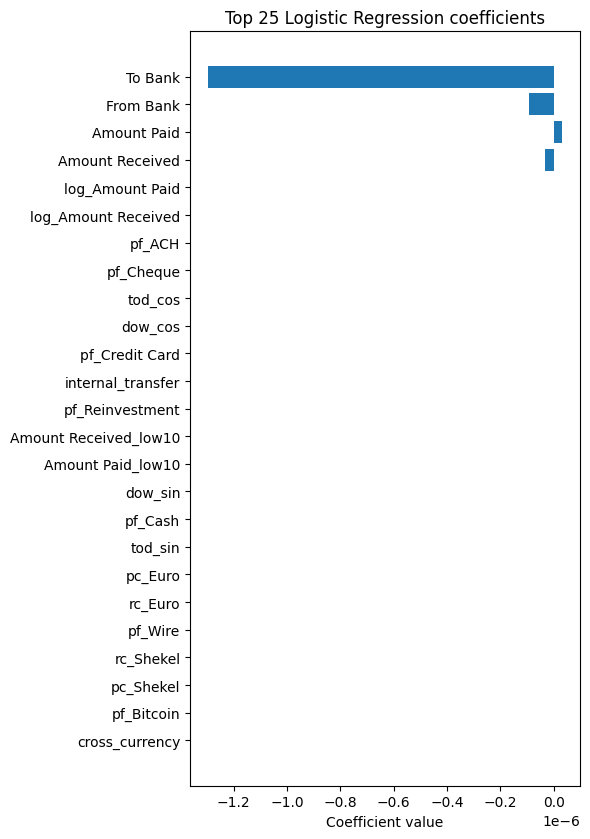

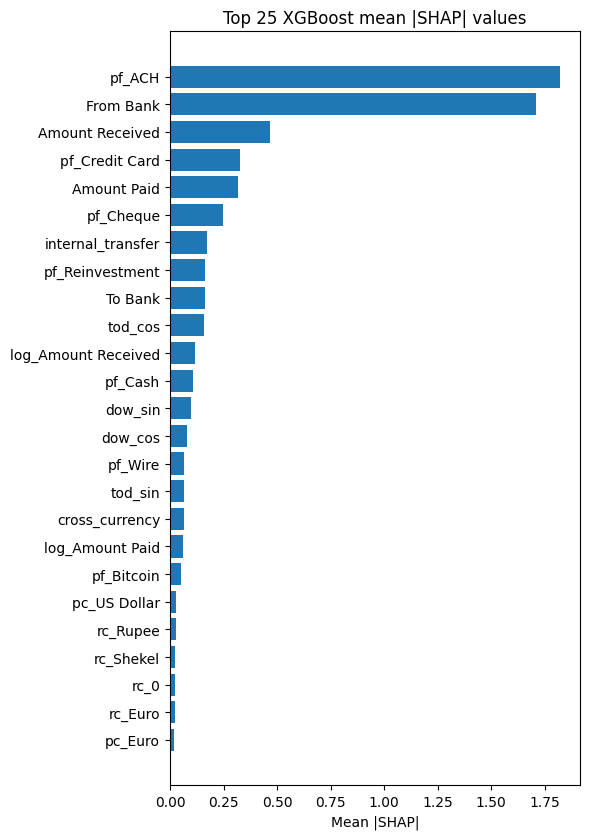

In [22]:
plot_lr_coefficients(lr_coef_df, top=25)
plt.show()

plot_xgb_shap(xgb_shap_df, top=25)
plt.show()

Logistic regression struggled with this one. We can only see the coefficients for four of the variables, because the others are orders of magnitude smaller. It seems nonlinear interactions were pivotal to predicting on this dataset

| model | mean AP | mean ROC‑AUC | mean F1 |
|-------|---------|--------------|---------|
| Logistic Regression | 0.002 | 0.53 | 0.004 |
| XGBoost | **0.082** | **0.95** | **0.149** |


## Preprocessing #2

To try to improve performance from the baseline models, let's try:

- oversampling the minority class using Smote

In [23]:
data = data_orig.copy()

data = feature_engineering_V1(data)

data

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,pc_Yuan,pf_ACH,pf_Bitcoin,pf_Cash,pf_Cheque,pf_Credit Card,pf_Reinvestment,pf_Wire,internal_transfer,cross_currency
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,...,False,False,False,False,False,False,True,False,1,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,...,False,False,False,False,True,False,False,False,0,0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,...,False,False,False,False,False,False,True,False,1,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,...,False,False,False,False,False,False,True,False,1,0
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,...,False,False,False,False,False,False,True,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022-09-10 23:57:00,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,...,False,False,True,False,False,False,False,False,0,0
5078341,2022-09-10 23:35:00,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,...,False,False,True,False,False,False,False,False,0,0
5078342,2022-09-10 23:52:00,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,...,False,False,True,False,False,False,False,False,0,0
5078343,2022-09-10 23:46:00,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,...,False,False,True,False,False,False,False,False,1,0
